In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy.stats import logistic
from scipy import stats

# Investigating Sports Team Success and Housing Prices

## Introduction:

In this assignment, you will analyze a dataset to evaluate whether investing in sports teams could potentially boost the economy of US cities through increasing housing prices. As a data scientist hired by a policymaker, your task is to provide evidence supporting or refuting the claims made by sports teams regarding their economic benefits. 

In [3]:
# Let's read in the data.
file_path = '/Users/mirandashen/Desktop/Villas-Boas_2023pset3.dta'
df = pd.read_stata(file_path)
print(df)

              city state  pricesept2021  successteams  violentcrime2019  \
0         Chandler    AZ           1450             0             0.593   
1          Gilbert    AZ           1660             0             0.245   
2         Glendale    AZ           1130             0             0.863   
3             Mesa    AZ           1160             0             1.953   
4          Phoenix    AZ           1260             1            11.803   
..             ...   ...            ...           ...               ...   
93        Richmond    VA           1090             0             1.068   
94  Virginia Beach    VA           1290             0             0.581   
95         Seattle    WA           1690             1             4.471   
96         Spokane    WA           1000             0             1.520   
97         Madison    WI           1250             0             0.940   

    numberbars  aqi2020         gdp    popul2019  nteams  
0           79      119  237.470001   25

This dataset contains characteristics for 98 US cities from 2019 to 2021. You will investigate the following variables:

| Variable      | Definition                                           | Source             |
|---------------|------------------------------------------------------|--------------------|
| city          | City name                                            |                    |
| state         | State name                                           |                    |
| pricesept2021 | One bedroom housing price, in USD                   | www.Zumper.com     |
| successteams  | Dummy variable =1 if at least one NBA, NFL, or MLB team in a city had a winning record last season (2020 season), =0 otherwise | Google search |
| violentcrime2019 | Violent crimes (in thousands)                      | FBI                |
| numberbars    | Number of bars, count                               | www.yellowpages.com|
| aqi2020       | Annual 2020 air quality index (AQI)                 | EPA                |
| gdp           | Gross domestic product (billion $)                  | BEA                |
| popuul2019    | 2019 population (in thousands of people)            | FBI                |
| nteams        | Number of major professional sports teams           | Google search      |


Run the following cell to group the dataset by the success of sports teams in each city and plot histograms of one-bedroom housing prices for cities with successful and unsuccessful sports teams. The x-axis represents housing prices in USD, and the y-axis represents frequency.

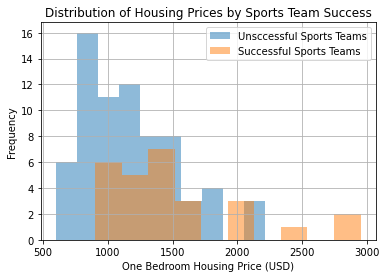

In [4]:
grouped_data = df.groupby('successteams')
grouped_data['pricesept2021'].hist(alpha=0.5, bins=10)
plt.xlabel('One Bedroom Housing Price (USD)')
plt.ylabel('Frequency')
plt.legend(['Unsccessful Sports Teams', 'Successful Sports Teams'])
plt.title('Distribution of Housing Prices by Sports Team Success')
plt.show()

## Question 1:

What do you notice about the housing prices for cities with a successful sports team versus cities without a successful sports team?

##### Type answer here.

Interesting! Let's dig a big deeper and calculate the means and 95% confidence intervals for the medians of each group.

In [5]:
# Group the dataset by 'successteams'
grouped_data = df.groupby('successteams')

# Calculate the mean of 'pricesept2021' for each group
mean_prices = grouped_data['pricesept2021'].mean()
print(mean_prices)

successteams
0    1170.422535
1    1507.407407
Name: pricesept2021, dtype: float64


In [6]:
# Function to perform bootstrapping for median calculation
def bootstrap_median(data):
    resamples = data.sample(n=len(data), replace=True)
    return np.percentile(resamples['pricesept2021'], 50)

# Number of repetitions for bootstrapping
num_repetitions = 1000

# Bootstrap medians for each group
no_success = []
success = []

# Perform bootstrapping for each group
for i in range(num_repetitions):
    no_success.append(bootstrap_median(grouped_data.get_group(0)))
    success.append(bootstrap_median(grouped_data.get_group(1)))

# Convert bootstrap medians lists to numpy arrays for further analysis
no_success = np.array(no_success)
success = np.array(success)

# Calculate confidence intervals for each group
no_success_ci = np.percentile(no_success, [2.5, 97.5])
success_ci = np.percentile(success, [2.5, 97.5])

# Print confidence intervals
print("95% Confidence Interval for Group 0 (No Successful Sports Teams):", no_success_ci)
print("95% Confidence Interval for Group 1 (Successful Sports Teams):", success_ci)

95% Confidence Interval for Group 0 (No Successful Sports Teams): [ 980. 1210.]
95% Confidence Interval for Group 1 (Successful Sports Teams): [1190. 1610.]


We can see the mean housing price for a city with no winning sports teams is $1,170.42 and for a city with at least one winning sports team is $1,507.40. Similarly, we have our two 95% confidence intervals for the medians: [$980, $1,210] for a city with no winning sports teams and [$1,190, $1,610] for a city with at least one winning sports team.

This provides some more insights in how pricing specifically differs. To really get a solidified answer, the policymaker has asked you to carry out a hypothesis test.

## Question 2:

What is the null and alternative hypothesis?

##### Type answer here.

Run the code below to perform a permutation test and obtain the p-value for the observed difference in mean housing prices. 

In [7]:
# Get the data for each group
data_group0 = grouped_data.get_group(0)['pricesept2021']
data_group1 = grouped_data.get_group(1)['pricesept2021']

# Calculate the observed difference in mean housing prices between the two groups
observed_diff_mean = mean_prices[1] - mean_prices[0]

# Concatenate the data from both groups
concatenated_data = np.concatenate([data_group0, data_group1])

# Initialize an empty array to store permutation test results
perm_diff_means = np.empty(1000)

# Perform permutation test
for i in range(1000):
    np.random.shuffle(concatenated_data)  # Shuffle the concatenated data
    perm_group0 = concatenated_data[:len(data_group0)]  # Create permutation group 0
    perm_group1 = concatenated_data[len(data_group0):]  # Create permutation group 1
    perm_diff_means[i] = perm_group1.mean() - perm_group0.mean()  # Calculate difference in means

# Calculate p-value for the observed difference in mean housing prices
p_value_01 = np.sum(np.abs(perm_diff_means) >= np.abs(observed_diff_mean)) / len(perm_diff_means)

# Print the results for the 1% level
print("P-Value (1% level):", p_value_01)

P-Value (1% level): 0.002


Wow! That's a small p-value. Excited by the significant findings, the policymaker wastes no time in drafting key proposals aimed at leveraging the success of sports teams to drive economic growth:

#### Policy 1: Sports Infrastructure Investment
Invest in modern sports facilities to attract events and boost local businesses.

#### Policy 2: Sports Education and Training Programs
Expand sports programs in schools to develop talent and promote active lifestyles.

#### Policy 3: Sports Tourism Promotion
Market the city as a premier sports tourism destination to attract visitors.

#### Policy 4: Community Engagement and Outreach
Organize grassroots sports leagues and cultural events to build community spirit.

## Question 3:

Which of the four policies would you recommend the policymaker push forward? Feel free to run some exploratory data analyses on the dataset to support your answer.

In [8]:
# CODE HERE

##### Type answer here.

The policymaker presents the proposed policy to the mayor, expecting approval, but the mayor is skeptical. "Is the most important thing we should be focusing on...sports?" the mayor questions.

Let's run some more analyses to see if we're missing something important.

## Orders of Understanding:

The following code reverses our equation. Run the cell below to use logistic regression to determine the effect of housing prices on whether or not a city will have at least one winning sports team.

In [14]:
# Reshape data for sklearn
X = np.array(df['pricesept2021']).reshape(-1, 1)
y = np.array(df['successteams'])

# Initialize logistic regression model
log_reg = LogisticRegression()

# Fit the model
log_reg.fit(X, y)

# Extract coefficients
coefficients = log_reg.coef_[0]
intercept = log_reg.intercept_

# Print the results
print("Coefficients:", coefficients)
print("Intercept:", intercept)

# Get the standard errors for the coefficients
se_coefficient = np.sqrt(np.diag(log_reg.coef_))

# Compute z-value for the coefficient
z_value = coefficients / se_coefficient

# Compute p-value for the coefficient
p_value = 2 * (1 - logistic.cdf(np.abs(z_value)))

# Print the p-value
print("P-Value for Coefficient:", p_value)

Coefficients: [0.00165181]
Intercept: [-3.14054606]
P-Value for Coefficient: [0.97968155]


## Question 3:

Interpret the results of this logistic regression model.

##### Type answer here.

## Investigating Additional Variables:

As mentioned previously, this dataset has several variables that represent different features of each US city. The policymaker starts wondering if there is a different variable from sports team success that also has an impact on housing prices. 

Let's navigate two new variables: aqi2020 (annual 2020 air quality index) and violentcrime2019 (violent crime in thousands).

Run the code below to run a linear regression model on the impact of aqi2020 and violentcrime2019 on housing prices.

In [15]:
def calculate_p_value(df, independent_var, dependent_var):
    # Prepare the data
    X = df[independent_var].values.reshape(-1, 1)  # Reshape to 2D array
    y = df[dependent_var]
    
    # Fit the Linear Regression model
    model = LinearRegression().fit(X, y)
    # Calculate the residuals
    residuals = y - model.predict(X)
    # Calculate the standard error of the residuals
    std_error_residuals = np.std(residuals, ddof=1)  # ddof=1 for sample standard deviation
    # Calculate the standard error of the coefficient
    std_error_coef = std_error_residuals / np.sqrt(np.sum((X - np.mean(X))**2))
    # Calculate the t-statistic
    t_statistic = model.coef_[0] / std_error_coef
    # Calculate the degrees of freedom
    dof = len(df) - 2  # Number of observations - number of parameters (intercept and independent variable)
    # Calculate the p-value
    p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), dof))  # Two-tailed p-value
    
    return p_value

# Calculate p-value for 'aqi2020'
p_value_aqi = calculate_p_value(df, 'aqi2020', 'pricesept2021')
print("P-Value for 'aqi2020':", p_value_aqi)

# Calculate p-value for 'violentcrime2019'
p_value_crime = calculate_p_value(df, 'violentcrime2019', 'pricesept2021')
print("P-Value for 'violentcrime2019':", p_value_crime)

P-Value for 'aqi2020': 0.026659487774263413
P-Value for 'violentcrime2019': 0.0003500758355690081


## Question 4

Interpret  the results of this linear regression model.

##### Type answer here.

## Reflection

How orders of understanding in our analysis of housing prices and successful sports teams impact the decisions made by our policy makers?

Can you recall a situation where you or others narrowed our focus to the point of missing out on key data in an analysis? How did this affect our decision-making process?

Why is it important for our real estate company to be cautious of expressing high levels of confidence in our findings about the impact of sports team success on housing prices?

Explain how recognizing multiple causes of varying importance, such as housing prices, air quality, and crime rates, contributes to our understanding of the relationship between sports team success and housing prices.

Discuss the ethical considerations involved in deciding which factors to include or exclude when modeling the relationship between housing prices and sports team success. How can our values inform these decisions?
